In [1]:
from keras.applications import VGG16

"VGG16 이라는 이미 훈련된 네트워크(모델)을 사용할 것이다."

conv_base = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (150, 150, 3))
"모델을 초기화할 가중치를  imagenet으로 줬다."
"include_top 은 dense층과 같은 완전연결분류기를 모델에 포함 시킬 것인지 묻는거다 우리는 2개의 분류만 진행하기 때문에 false한다."
"imagenet은 1000개의 분류를 진행 하므로.."

conv_base.summary()

Using TensorFlow backend.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [2]:
"데이터 증식을 사용하지 않는 빠른 특성 추출"

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

"특성 추출"
def extract_features(directory, sample_count) :
    features = np.zeros(shape = (sample_count, 4,4, 512))
    labels = np.zeros(shape = (sample_count))
    "directory에 있는 image를 rescale"
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size = batch_size,
        class_mode = 'binary')
    
    i = 0
    "batch_size=20 따라서 for문 1번에 20번까지 들어간다. 그래서 features배열에 0부터 20번까지 20개씩 넣음"
    for inputs_batch, labels_batch in generator :
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
"추출된 특성의 크기는 (sample, 4,4,512)인 4D 이다. Dense층에 넣기 위해서 2D형태로 변경해줘야한다."
train_features = np.reshape(train_features, (2000,4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000,4*4*512))

In [4]:
from keras import models
from keras import layers
from keras import optimizers
"데이터 증식을 사용하지 않는 빠른 특성 추출"
model = models.Sequential()

model.add(layers.Dense(256, activation = 'relu', input_dim =  4 * 4* 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
             optimizer = optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs = 30,
                   batch_size= 20,
                   validation_data = (validation_features, validation_labels))


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 962us/step - loss: 0.5921 - acc: 0.6765 - val_loss: 0.4255 - val_acc: 0.8440
Epoch 2/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4207 - acc: 0.8070 - val_loss: 0.3555 - val_acc: 0.8670
Epoch 3/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3487 - acc: 0.8530 - val_loss: 0.3178 - val_acc: 0.8810
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3072 - acc: 0.8725 - val_loss: 0.2938 - val_acc: 0.8880
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2758 - acc: 0.8970 - val_loss: 0.2791 - val_acc: 0.8900
Epoch 6/30
2000/2000 [==============================] - 2s 994us/step - loss: 0.2618 - acc: 0.8995 - val_loss: 0.2777 - val_acc: 0.8860
Epoch 7/30
2000/2000 [==============================] - 2s 887us/step - loss: 0.2423 - acc: 0.9010 - val_loss: 0.2606 - val_acc: 0.8910
Epoch 8/

== Average Scores ==
Accuracy :  0.9261834
Validation Accuracy :  0.8949666639169057

Loss :  0.1892777568716556
Validation Loss :  0.2572125978370508


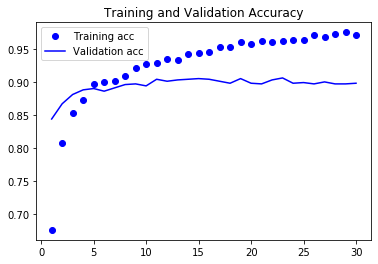

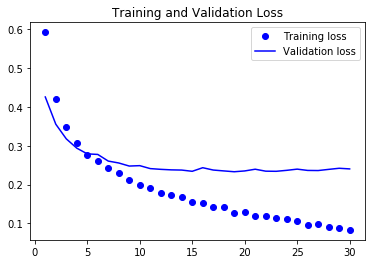

In [5]:
import matplotlib.pyplot as plt
import numpy as np

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

print("== Average Scores ==\nAccuracy : ", np.mean(acc))
print("Validation Accuracy : ", np.mean(val_acc))
print()
print("Loss : ", np.mean(loss))
print("Validation Loss : ", np.mean(val_loss))

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

"높은 Dropout비율을 사용했어도 훈련 시작하면서 거의 바로 overfitting이 적용된다."
"이미지 데이터가 적을 때 사용하는 이미지 증식을 사용하지 않았기 때문."

plt.show()

In [6]:
from keras import models
from keras import layers

model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [7]:
"이미 훈련된 모델을 컴파일하고 훈련하기 전에 합성곱 층을 !!!동결!!!하는 것이 매우 중요!!!"
"동결 : 훈련하는 동안 가중치가 업데이트 되지 않게 하는것."
"동결을 하지 않으면 기존 학습된 표현이 훈련하는 동안 수정된다."
"keras에서는 trainable속성을 false로 설정하여 네트워크를 동결할 수 있다."

print('conv_base를 동결 하기 전 훈련되는 가중치 수 : ',
     len(model.trainable_weights))

conv_base.trainable = False

print('conv_base를 동결한 후 훈련되는 가중치 수 : ',
     len(model.trainable_weights))


conv_base를 동결 하기 전 훈련되는 가중치 수 :  30
conv_base를 동결한 후 훈련되는 가중치 수 :  4


In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
"데이터 증식을 활용한 특성추출"
train_datagen = ImageDataGenerator(
                rescale = 1./255,
                rotation_range = 20,
                width_shift_range = 0.1,
                height_shift_range = 0.1,
                shear_range = 0.1,
                zoom_range = 0.1,
                horizontal_flip = True,
                fill_mode = 'nearest')

"테스트 데이터는 증식되선 안됨!!"
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size = (150,150),
                batch_size = 20,
                class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
                validation_dir,
                target_size = (150,150),
                batch_size = 20,
                class_mode = 'binary')

model.compile(loss = 'binary_crossentropy',
             optimizer = optimizers.RMSprop(lr = 2e-5),
             metrics = ['acc'])

history = model.fit_generator(
            train_generator,
            steps_per_epoch = 100,
            epochs = 30,
            validation_data = validation_generator,
            validation_steps = 50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 35s 347ms/step - loss: 0.5336 - acc: 0.7430 - val_loss: 0.3112 - val_acc: 0.8490
Epoch 2/30
100/100 [==============================] - 31s 312ms/step - loss: 0.4111 - acc: 0.8230 - val_loss: 0.3242 - val_acc: 0.8730
Epoch 3/30
100/100 [==============================] - 31s 310ms/step - loss: 0.3493 - acc: 0.8540 - val_loss: 0.2733 - val_acc: 0.8760
Epoch 4/30
100/100 [==============================] - 31s 311ms/step - loss: 0.3175 - acc: 0.8665 - val_loss: 0.2623 - val_acc: 0.8900
Epoch 5/30
100/100 [==============================] - 31s 313ms/step - loss: 0.2962 - acc: 0.8755 - val_loss: 0.2073 - val_acc: 0.8920
Epoch 6/30
100/100 [==============================] - 31s 311ms/step - loss: 0.2853 - acc: 0.8825 - val_loss: 0.2285 - val_acc: 0.8930
Epoch 7/30
100/100 [==============================] - 31s 313ms/step - loss: 0.2738 - acc: 0.8945 - val_lo

== Average Scores ==
Accuracy :  0.8978167
Validation Accuracy :  0.8963999966780345

Loss :  0.24807509467254082
Validation Loss :  0.2567128218710423


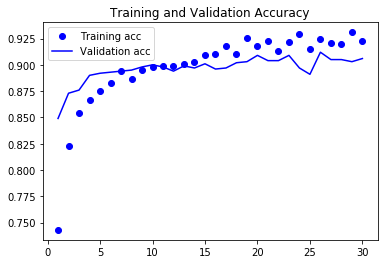

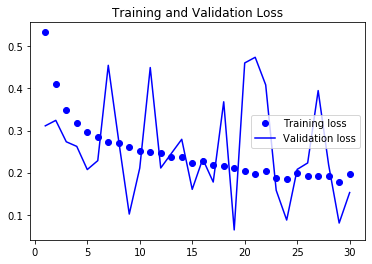

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']



epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
"정확도는 거의 대로지만 Overfitting은 줄었다."
plt.show()

In [10]:
"미세조정 : 특성 추출에 사용했던 동결 모델에서 상위 층 몇개만 동결 해제하여 새로 추가한 층(여기선 Dense층)과 함께 훈련"
"분류기(Dense층)가 훈련된 후에 미세 조정을 해야함. 그렇지 않으면 너무 큰 오차가 네트워크에 전파되어 학습한 표현이 부서짐"
"단계 1 : 훈련된 기반 네트워크 위에 로운 네트워크 추가."
"단계 2 : 기반 네크워크  동결"
"단계 3 : 새로 추가한 네트워크 훈련"
"단계 4 : 네트워크 일부 의 동결을 해제"
"단계 5 : 동결을 해제한 층과 추가한 층을 함께 훈련"

conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers :
    if layer.name == 'block5_conv1' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else : 
        layer.trainable = False

        
        
model.compile(loss = 'binary_crossentropy',
             optimizer = optimizers.RMSprop(lr=1e-5),
             metrics = ['acc'])


history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = 50)


Epoch 1/100
100/100 [==============================] - 39s 388ms/step - loss: 0.2013 - acc: 0.9170 - val_loss: 0.0810 - val_acc: 0.9130
Epoch 2/100
100/100 [==============================] - 36s 362ms/step - loss: 0.1609 - acc: 0.9380 - val_loss: 0.4484 - val_acc: 0.9020
Epoch 3/100
100/100 [==============================] - 36s 363ms/step - loss: 0.1431 - acc: 0.9355 - val_loss: 0.2476 - val_acc: 0.9150
Epoch 4/100
100/100 [==============================] - 36s 363ms/step - loss: 0.1275 - acc: 0.9510 - val_loss: 0.3939 - val_acc: 0.9300
Epoch 5/100
100/100 [==============================] - 36s 364ms/step - loss: 0.1057 - acc: 0.9565 - val_loss: 0.0101 - val_acc: 0.9290
Epoch 6/100
100/100 [==============================] - 36s 363ms/step - loss: 0.0984 - acc: 0.9605 - val_loss: 0.1546 - val_acc: 0.9140
Epoch 7/100
100/100 [==============================] - 37s 365ms/step - loss: 0.0852 - acc: 0.9700 - val_loss: 0.2244 - val_acc: 0.9220
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 33s 328ms/step - loss: 0.0038 - acc: 0.9990 - val_loss: 1.1291 - val_acc: 0.9370
Epoch 62/100
100/100 [==============================] - 33s 333ms/step - loss: 0.0044 - acc: 0.9985 - val_loss: 0.0026 - val_acc: 0.9300
Epoch 63/100
100/100 [==============================] - 34s 338ms/step - loss: 0.0053 - acc: 0.9980 - val_loss: 0.3904 - val_acc: 0.9360
Epoch 64/100
100/100 [==============================] - 33s 327ms/step - loss: 9.9019e-04 - acc: 1.0000 - val_loss: 0.7682 - val_acc: 0.9320
Epoch 65/100
100/100 [==============================] - 33s 325ms/step - loss: 0.0038 - acc: 0.9985 - val_loss: 0.5766 - val_acc: 0.9290
Epoch 66/100
100/100 [==============================] - 32s 324ms/step - loss: 0.0025 - acc: 0.9990 - val_loss: 0.2821 - val_acc: 0.9410
Epoch 67/100
100/100 [==============================] - 32s 323ms/step - loss: 0.0044 - acc: 0.9995 - val_loss: 0.0516 - val_acc: 0.9320
Epoch 68/100
100/100 [===============

== Average Scores ==
Accuracy :  0.9928
Validation Accuracy :  0.9297999995946884

Loss :  0.019692728094747633
Validation Loss :  0.3802311178790114


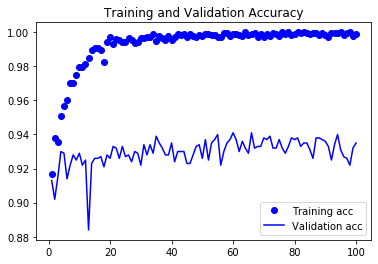

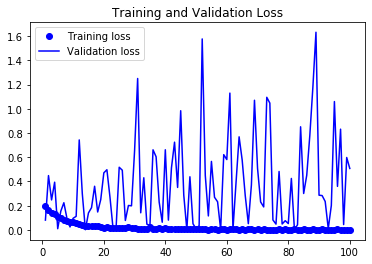

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

print("== Average Scores ==\nAccuracy : ", np.mean(acc))
print("Validation Accuracy : ", np.mean(val_acc))
print()
print("Loss : ", np.mean(loss))
print("Validation Loss : ", np.mean(val_loss))

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
"정확도는 거의 대로지만 Overfitting은 줄었다."
plt.show()

== Average Scores ==
Accuracy :  0.9928
Validation Accuracy :  0.9297999995946884

Loss :  0.019692728094747633
Validation Loss :  0.3802311178790114


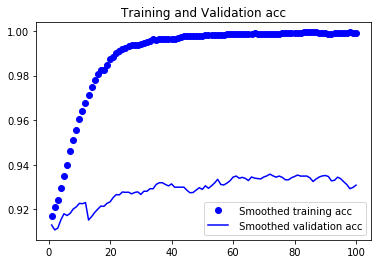

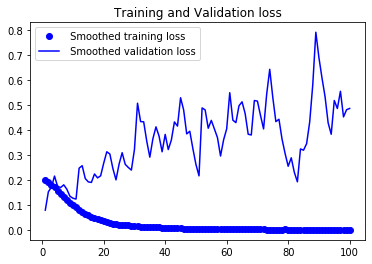

In [13]:
"지수이동평균"
def smooth_curve(points, factor = 0.8) :
    smoothed_points = []
    for point in points :
        if smoothed_points :
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else :
            smoothed_points.append(point)
    return smoothed_points

print("== Average Scores ==\nAccuracy : ", np.mean(acc))
print("Validation Accuracy : ", np.mean(val_acc))
print()
print("Loss : ", np.mean(loss))
print("Validation Loss : ", np.mean(val_loss))

plt.plot(epochs, smooth_curve(acc), 'bo', label = ' Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label = ' Smoothed validation acc')
plt.title('Training and Validation acc')
plt.legend()
plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label = ' Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label = ' Smoothed validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()


